# Fraud detection using labelled data
Now that you're familiar with the main challenges of fraud detection, you're about to learn how to flag fraudulent transactions with supervised learning. You will use classifiers, adjust them and compare them to find the most efficient fraud detection model.

## Natural hit rate
In this exercise, you'll again use credit card transaction data. The features and labels are similar to the data in the previous chapter, and the data is heavily imbalanced. We've given you features X and labels y to work with already, which are both numpy arrays.

First you need to explore how prevalent fraud is in the dataset, to understand what the "natural accuracy" is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" you need to "beat" in order to get a better prediction than by doing nothing. In the following exercises, you'll create our first random forest classifier for fraud detection. That will serve as the "baseline" model that you're going to try to improve in the upcoming exercises.

In [1]:
# Import pandas and read csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(np.float)
    y = df.iloc[:, 29]
    y=np.array(y).astype(np.float)
    return X,y

# Load Data
df = pd.read_csv("data/creditcard_data.csv").drop('Unnamed: 0',axis=1)
X, y = prep_data(df)

# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)

99.00990099009901


This tells us that by doing nothing, we would be correct in 95.9% of the cases. So now you understand, that if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct. Let's see how a random forest does in predicting fraud in our data.

## Random Forest Classifier - part 1
Let's now create a first random forest classifier for fraud detection. Hopefully you can do better than the baseline accuracy you've just calculated, which was roughly 96%. This model will serve as the "baseline" model that you're going to try to improve in the upcoming exercises. Let's start first with splitting the data into a test and training set, and defining the Random Forest model. The data available are features X and labels y.

In [2]:
# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)

## Random Forest Classifier - part 2
Let's see how our Random Forest model performs without doing anything special to it. The model from the previous exercise is available, and you've already split your data in X_train, y_train, X_test, y_test.

In [3]:
from sklearn.metrics import accuracy_score, precision_recall_curve

# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data
predicted = model.predict(X_test)

# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

0.9986798679867986


## Performance metrics for the RF model
In the previous exercises you obtained an accuracy score for your random forest model. This time, we know accuracy can be misleading in the case of fraud detection. With highly imbalanced fraud data, the AUROC curve is a more reliable performance metric, used to compare different classifiers. Moreover, the classification report tells you about the precision and recall of your model, whilst the confusion matrix actually shows how many fraud cases you can predict correctly. So let's get these performance metrics.

In [5]:
# Import the packages to get the different performance metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtain the predictions from our random forest model
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9993687707641195
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.90      0.90      0.90        10

    accuracy                           1.00      1515
   macro avg       0.95      0.95      0.95      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   1    9]]


You have now obtained more meaningful performance metrics that tell us how well the model performs, given the highly imbalanced data that you're working with. The model predicts 76 cases of fraud, out of which 73 are actual fraud. You have only 3 false positives. This is really good, and as a result you have a very high precision score. You do however, don't catch 18 cases of actual fraud. Recall is therefore not as good as precision. Let's try to improve that in the following exercises.

## Plotting the Precision Recall Curve
You can also plot a Precision-Recall curve, to investigate the trade-off between the two in your model. In this curve Precision and Recall are inversely related; as Precision increases, Recall falls and vice-versa. A balance between these two needs to be achieved in your model, otherwise you might end up with many false positives, or not enough actual fraud cases caught. To achieve this and to compare performance, the precision-recall curves come in handy.

Your Random Forest Classifier is available as model, and the predictions as predicted. You can simply obtain the average precision score and the PR curve from the sklearn package. The function plot_pr_curve() plots the results for you. Let's give it a try.

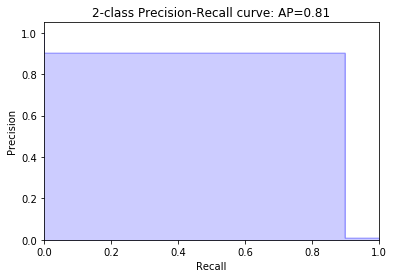

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(recall, precision, average_precision):
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
  plt.show()

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

The ROC curve plots the true positives vs. false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.

## Model adjustments
A simple way to adjust the random forest model to deal with highly imbalanced fraud data, is to use the class_weights option when defining your sklearn model. However, as you will see, it is a bit of a blunt force mechanism and might not work for your very special case.

In this exercise you'll explore the weight = "balanced_subsample" mode the Random Forest model from the earlier exercise. You already have split your data in a training and test set, i.e X_train, X_test, y_train, y_test are available. The metrics function have already been imported.



In [8]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9994019933554817
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   2    8]]


You can see that the model results don't improve drastically. We now have 3 less false positives, but now 19 in stead of 18 false negatives, i.e. cases of fraud we are not catching. If we mostly care about catching fraud, and not so much about the false positives, this does actually not improve our model at all, albeit a simple option to try. In the next exercises you'll see how to more smartly tweak your model to focus on reducing false negatives and catch more fraud.